In [ ]:
!pip install Dash
!pip install dash-ag-grid
!pip install dash_bootstrap_components

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import plotly.express as px

import dash
import dash_ag_grid as dag
import dash_core_components as dcc
import dash_html_components as html, dash_table
from dash.dependencies import Input, Output, State

import dash_bootstrap_components as dbc

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/analysis.xlsx')

In [ ]:
df.head()

,State,LGA,Ward,PU-Code,PU-Name,APC,LP,PDP,NNPP,Latitude,...,NNPP_mean,NNPP_std,total_mean,total_std,Z_APC,Z_LP,Z_NNPP,Z_PDP,Z_total,Name
0,RIVERS,ASARI-TORU,ISIA GROUP I,32-06-11-020,ELEM IFOKO I,518,5,23,0,4.761450,...,0.00000,1.000000,5.000000,0.000000,516.000000,3.000000,0.000000,22.000000,inf,"ELEM IFOKO I, ASARI-TORU"
1,RIVERS,AHOADA EAST,UPPATA II,32-02-06-012,TOWN HALL OZOCHI,279,3,2,0,4.956270,...,0.00000,1.000000,100.000000,0.000000,195.000000,6.000000,0.000000,5.000000,inf,"TOWN HALL OZOCHI, AHOADA EAST"
2,RIVERS,AHOADA EAST,UPPATA II,32-02-06-013,IGBU-OSHI OZOCHI RIVER SIDE,84,9,7,0,4.956270,...,0.00000,1.000000,284.000000,0.000000,195.000000,6.000000,0.000000,5.000000,-inf,"IGBU-OSHI OZOCHI RIVER SIDE, AHOADA EAST"
3,RIVERS,OYIGBO,KOMKOM,32-21-10-007,VILLAGE SQUARE,500,4,65,60,4.874907,...,0.30303,0.758182,124.772727,98.281491,153.202323,1.213889,78.737036,5.128421,5.130440,"VILLAGE SQUARE, OYIGBO"
4,RIVERS,KHANA,BANE,32-14-10-004,GBOR/LUMENE,81,29,67,1,4.649730,...,0.00000,1.000000,49.000000,11.000000,103.000000,3.833333,1.000000,11.888889,11.727273,"GBOR/LUMENE, KHANA"


In [ ]:
def replace_zero_std(df):
  for col in ['APC_std', 'LP_std', 'NNPP_std', 'PDP_std']:
    df.loc[df[col] == 0, col] = 1
  return df

df = replace_zero_std(df)

In [ ]:
# prompt: create column Z_APC as the APC column - APC_mean column divided by APC_std d do similar for LP, NNPC, PDP

df['Z_APC'] = abs(df['APC'] - df['APC_mean']) / df['APC_std']
df['Z_LP'] =abs(df['LP'] - df['LP_mean']) / df['LP_std']
df['Z_NNPP'] = abs(df['NNPP'] - df['NNPP_mean']) / df['NNPP_std']
df['Z_PDP'] = abs(df['PDP'] - df['PDP_mean']) / df['PDP_std']
df['Z_total'] = (df['total'] - df['total_mean']) / df['total_std']
df['Name'] = df['PU-Name'] + ', ' + df['LGA']
df.fillna(0, inplace=True)


In [ ]:
df = df.sort_values('Z_APC', ascending =False)

In [ ]:
df.to_excel('analysis.xlsx',index=False)

## Setting Params

In [ ]:
thresh = 5
count_threshold = 3

In [ ]:
min_lat = df['Latitude'].min()
max_lat = df['Latitude'].max()
min_long = df['Longitude'].min()
max_long = df['Longitude'].max()

In [ ]:
color_scale = [
     [0, 'rgba(125, 0, 0, 0.3)'],
     [0.2, 'rgba(150, 0, 0, 0.4)'],
     [0.4, 'rgba(200, 0, 0, 0.5)'],
     [0.6, 'rgba(255, 0, 0, 0.6)'],
    [0.8, 'rgba(255, 0, 0, 0.8)'],
    [1, 'rgba(255, 0, 0, 1)'],
]

## Top 5 outliers for each Party.

### Top 5 APC Outliers

In [ ]:
Pl_APC_df = df[(df['Z_APC'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_APC', ascending=False)
sub_Pl_APC_df = Pl_APC_df[['Name', 'Latitude', 'Longitude', 'Z_APC','APC','APC_mean','APC_std','count']]
sub_Pl_APC_df.head()

,Name,Latitude,Longitude,Z_APC,APC,APC_mean,APC_std,count
3,"VILLAGE SQUARE, OYIGBO",4.874907,7.134533,153.202323,500,1.840909,3.251642,132
14,"AGWUO/AWHUA OMAGWA, IKWERRE",5.020634,6.874301,38.061114,191,13.750000,4.656984,4
16,"AGADA I, SCHOOL HALL, ABUA-ODUAL",4.801506,6.687099,33.798165,562,21.800000,15.983116,20
33,"STATE SCHOOL HALL, OKOLOMADE II, ABUA-ODUAL",4.821016,6.511460,13.268363,81,21.333333,4.496913,3
36,"MGBUCHI/ELEDO TOWN RUKPOKU, OBIO/AKPOR",4.924600,6.995200,12.578233,299,16.134615,22.488483,52


In [ ]:
apc_total_outliers = len(Pl_APC_df)
apc_mean_z  = Pl_APC_df['Z_APC'].mean()
apc_std_z = Pl_APC_df['Z_APC'].std()
print(apc_total_outliers)

45


Extra:
- Because some values have very few counts they tend to have high Z values : some areas that arent so accessible may have only a few centres.
- for better insight I have also excluded those with lower counts

In [ ]:
fig = px.scatter_geo(  Pl_APC_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'APC', color = 'Z_APC',
                       hover_name = 'Name',
                     title = ' Distribution of  Outliers in the APC Party',
                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )


fig.update_geos(
  center = dict(
      lat =4.7639, #(min_lat + max_lat)/2,
      lon = 6.9523 #(min_long+max_long)/2,
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',
 )
fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)

fig.show()

The max value of the outlier score is around 140, A majority of the outlier values are less than 20.
The red shows areas with very high abnormaity.

### Top 5 PDP Outlier

In [ ]:
# ### Top 5 PDP Outliers
Pl_PDP_df = df[(df['Z_PDP'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_PDP', ascending=False)
sub_Pl_PDP_df = Pl_PDP_df[['Name', 'Latitude', 'Longitude', 'Z_PDP','PDP','PDP_mean','PDP_std','count']]
sub_Pl_PDP_df.head()

,Name,Latitude,Longitude,Z_PDP,PDP,PDP_mean,PDP_std,count
4438,0PEN SPACE BY 76 NVUIGWE RD BESIDE POLICE POST...,4.855528,6.994628,43.487272,243,3.411141,5.509402,377
459,"UMUMBRA TOWN HALL UMUOLA, OMUMA",4.890700,7.030380,29.393877,25,1.000000,0.816497,3
635,"OKAMA/ POLOKIRI VILLAGE SQUARE, ANDONI",4.511998,7.382942,26.217515,392,16.896000,14.307382,125
148,"OKOBOH TOWN HALL, ABUA-ODUAL",4.884460,6.618440,22.864577,152,6.142857,6.379175,7
938,"PEDRO'S COMPOUND BENIBO, AKUKU TORU",4.539604,6.747379,22.566498,272,14.480769,11.411573,156


In [ ]:
pdp_total_outliers = len(Pl_PDP_df)
pdp_mean_z = Pl_PDP_df['Z_PDP'].mean()
pdp_std_z = Pl_PDP_df['Z_PDP'].std()
print(pdp_total_outliers)


38


In [ ]:

fig = px.scatter_geo(  Pl_PDP_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'PDP', color = 'Z_PDP',
                       hover_name = 'Name',
                     title = ' Plot of  Outliers in the PDP Party',

                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )
fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)

fig.update_geos(
  center = dict(
      lat =4.7639, #(min_lat + max_lat)/2,
      lon = 6.9523 #(min_long+max_long)/2,
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',
)


fig.show()

### NNPP
####  TOP 5 Outliers For NNPP

In [ ]:
Pl_NNPP_df = df[(df['Z_NNPP'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_NNPP', ascending=False)
sub_Pl_NNPP_df = Pl_NNPP_df[['Name', 'Latitude', 'Longitude', 'Z_NNPP','NNPP','NNPP_mean','NNPP_std','count']]
sub_Pl_NNPP_df.head()

,Name,Latitude,Longitude,Z_NNPP,NNPP,NNPP_mean,NNPP_std,count
3044,"TOWN HALL, EGBEE, AHOADA WEST",5.043357,6.504660,261.817973,54,0.044444,0.206080,90
3,"VILLAGE SQUARE, OYIGBO",4.874907,7.134533,78.737036,60,0.303030,0.758182,132
486,"ABULOMA UPE III, PORT HARCOURT",4.779366,7.060843,68.967888,28,0.136364,0.404009,44
272,"STATE SCHOOL HALL, OBARANY, ABUA-ODUAL",4.857630,6.645190,67.066220,27,0.140000,0.400500,50
45,"KENNETH COMMERCIAL SCHOOL I, PORT HARCOURT",4.789949,6.988290,50.191187,25,0.204082,0.494029,147


In [ ]:
nnpp_total_outliers = len(Pl_NNPP_df)
nnpp_mean_z = Pl_NNPP_df['Z_NNPP'].mean()
nnpp_std_z = Pl_NNPP_df['Z_NNPP'].std()
print(nnpp_total_outliers)

56


In [ ]:

# ### Top 5 NNPP Outliers

fig = px.scatter_geo(  Pl_NNPP_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'NNPP', color = 'Z_NNPP',
                       hover_name = 'Name',
                     title = ' Distribution of  Outliers in the NNPP Party',
                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )


fig.update_geos(
  center = dict(
      lat =4.7639, #(min_lat + max_lat)/2,
      lon = 6.9523 #(min_long+max_long)/2,
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',
 )

fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)

fig.show()

### LP

#### TOP 5 LP Outliers

In [ ]:
# ### Top 5 LP Outliers
Pl_LP_df = df[(df['Z_LP'] > thresh) & (df['count']>=count_threshold)].sort_values(by='Z_LP', ascending=False)
sub_Pl_LP_df = Pl_LP_df[['Name', 'Latitude', 'Longitude', 'Z_LP','LP','LP_mean','LP_std','count']]
sub_Pl_LP_df.head()

,Name,Latitude,Longitude,Z_LP,LP,LP_mean,LP_std,count
862,"C.P.S I, BOTEM, TAI",4.730900,7.27657,114.054974,443,2.825000,3.859323,80
194,"TOWN HALL, OGODA, AHOADA WEST",5.115790,6.57502,28.730584,76,4.333333,2.494438,3
2428,"COMM. PRI. SCH. ISHIAYI, AHOADA WEST",5.043357,6.50466,16.045960,490,24.022222,29.040194,90
33,"STATE SCHOOL HALL, OKOLOMADE II, ABUA-ODUAL",4.821016,6.51146,15.202796,15,0.666667,0.942809,3
148,"OKOBOH TOWN HALL, ABUA-ODUAL",4.884460,6.61844,13.736956,57,4.857143,3.795809,7


In [ ]:
lp_total_outliers = len(Pl_LP_df)

lp_mean_z = Pl_LP_df['Z_LP'].mean()
lp_std_z = Pl_LP_df['Z_LP'].std()
print(lp_total_outliers)

34


In [ ]:
fig = px.scatter_geo(  Pl_LP_df,
                     lon ='Longitude', lat = 'Latitude',
                       size= 'LP', color = 'Z_LP',
                       hover_name = 'Name',
                     title = ' Distribution of  Outliers in the LP Party',
                     projection = 'natural earth',
                       color_continuous_scale=color_scale,
                       )


fig.update_geos(
  center = dict(
      lat =4.7639,
      lon = 6.9523
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',
 )
fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)


fig.show()

## Comparison Accross Parties

### Parties With the highest Number of outliers

In [ ]:

party_outliers = {
    "APC": apc_total_outliers,
    "PDP": pdp_total_outliers,
    "NNPP": nnpp_total_outliers,
    "LP": lp_total_outliers,
}

In [ ]:
import matplotlib.pyplot as plt

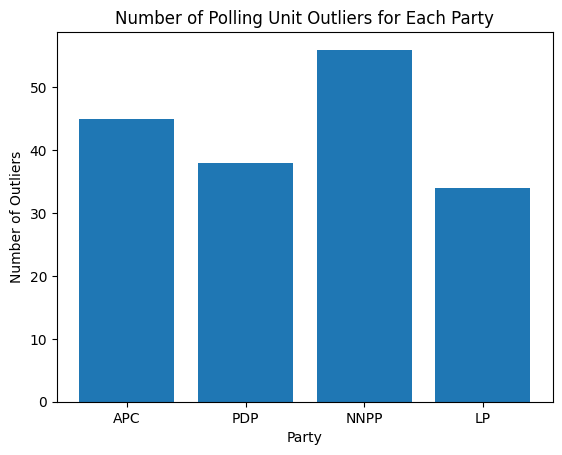

<BarContainer object of 4 artists>

In [ ]:
def plot_outliers():

  fig = plt.bar(party_outliers.keys(), party_outliers.values())
  plt.xlabel('Party')
  plt.ylabel('Number of Outliers')
  plt.title('Number of Polling Unit Outliers for Each Party')
  plt.show()
  return fig

plot_outliers()

In [ ]:
print(party_outliers)

{'APC': 45, 'PDP': 38, 'NNPP': 56, 'LP': 34}


Summary
The break down of the number of polling units with outliers is presented below
- APC : 45
- PDP : 38
- NNPP : 56
- LP : 36 \

In Summary NNPP has the highest occurence of outlier in a polling unit

### Parties With Huge outliers

In [ ]:
agg_mean =  df[['Z_APC', 'Z_PDP', 'Z_LP', 'Z_NNPP']].agg(['mean','std'])

agg_mean.rename(columns={'Z_APC': 'APC', 'Z_PDP': 'PDP', 'Z_LP': 'LP', 'Z_NNPP': 'NNPP',}, inplace=True)

agg_mean = agg_mean.T
agg_mean.reset_index(inplace=True, drop=False)
agg_mean.rename(columns={'index': 'Party'}, inplace=True)

agg_mean

,Party,mean,std
0,APC,1.354982,10.108211
1,PDP,0.988859,3.404325
2,LP,1.180912,5.290656
3,NNPP,0.639544,4.566702


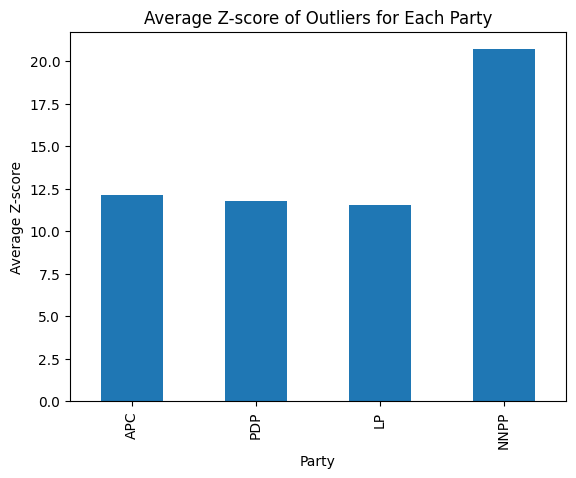

<Axes: title={'center': 'Average Z-score of Outliers for Each Party'}, xlabel='Party', ylabel='Average Z-score'>

In [ ]:
# prompt: find the average and std of the z value of apc. pdp, lp ,nnpp and make an error bar plot

# import matplotlib.pyplot as plt
# import pandas as pd

# Create a dictionary to store the data
data = {
    'Party': ['APC', 'PDP', 'LP', 'NNPP'],
    'mean': [apc_mean_z, pdp_mean_z, lp_mean_z, nnpp_mean_z],
    'std': [apc_std_z, pdp_std_z, lp_std_z, nnpp_std_z]
}

# Create a DataFrame
agg = pd.DataFrame(data)

# Create an error bar plot

def plot_ave_Z_score():
  fig = agg.plot(kind='bar', x= 'Party',  y='mean', legend=False)
  plt.xlabel('Party')
  plt.ylabel('Average Z-score')
  plt.title('Average Z-score of Outliers for Each Party')
  plt.show()

  return fig

plot_ave_Z_score()

In [ ]:
df.columns

Index(['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'APC', 'LP', 'PDP',
       'NNPP', 'Latitude', 'Longitude', 'count', 'total', 'APC_mean',
       'APC_std', 'PDP_mean', 'PDP_std', 'LP_mean', 'LP_std', 'NNPP_mean',
       'NNPP_std', 'total_mean', 'total_std', 'Z_APC', 'Z_LP', 'Z_NNPP',
       'Z_PDP', 'Z_total', 'Name'],
      dtype='object')

### Show all in One Plot

In [ ]:

adf = df[df['count']>=count_threshold][['Name', 'Latitude', 'Longitude', 'Z_APC', 'Z_LP', 'Z_NNPP', 'Z_PDP',
       'Z_total']]
adf_melt = adf.melt(id_vars=['Name', 'Latitude', 'Longitude'], var_name='Variable', value_name='Z_scores')
variable_mapping = {
    'Z_APC': 'APC',
    'Z_LP': 'LP',
    'Z_NNPP': 'NNPP',
    'Z_PDP': 'PDP',
    'Z_total': 'Total'
}
adf_melt = adf_melt.sort_values('Z_scores', ascending=False)
adf_melt['Variable'] = adf_melt['Variable'].map(variable_mapping)
adf_melt.head()




,Name,Latitude,Longitude,Variable,Z_scores
12296,"TOWN HALL, EGBEE, AHOADA WEST",5.043357,6.504660,NNPP,261.817973
0,"VILLAGE SQUARE, OYIGBO",4.874907,7.134533,APC,153.202323
5463,"C.P.S I, BOTEM, TAI",4.730900,7.276570,LP,114.054974
9322,"VILLAGE SQUARE, OYIGBO",4.874907,7.134533,NNPP,78.737036
9751,"ABULOMA UPE III, PORT HARCOURT",4.779366,7.060843,NNPP,68.967888


In [ ]:
adf_melt[adf_melt['Z_scores']>thresh].info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, 12296 to 12820
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       194 non-null    object 
 1   Latitude   194 non-null    float64
 2   Longitude  194 non-null    float64
 3   Variable   194 non-null    object 
 4   Z_scores   194 non-null    float64
dtypes: float64(3), object(2)
memory usage: 9.1+ KB


In [ ]:
adf_melt[adf_melt['Z_scores']>thresh]['Name'].nunique()

156

In [ ]:
adf_melt.to_excel('result.xlsx')

In [ ]:

fig = px.scatter_geo(adf_melt[adf_melt['Z_scores']>thresh],
                     lon ='Longitude', lat = 'Latitude',
                       size= 'Z_scores', color = 'Variable',
                       hover_name = 'Name',
                     title = ' Plot of  Outliers in the All Parties',

                     projection = 'natural earth',

                       )
fig.update_layout(
    title_x=0.5,
     title_xanchor = 'center',
)

fig.update_geos(
  center = dict(
      lat =4.7639, #(min_lat + max_lat)/2,
      lon = 6.9523 #(min_long+max_long)/2,
  ),
  projection_scale = 15,

showland = True,
landcolor = 'lightgreen',
  showocean = True,
  oceancolor = 'lightblue',
  showlakes = True,
  lakecolor = 'lightblue',
  showcountries = True,
  showrivers = True,
  rivercolor = 'blue',

)

fig.show()




In [91]:
# Initialize the app - incorporate a Dash Bootstrap theme

external_stylesheets = [dbc.themes.CERULEAN]
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)


grid = dag.AgGrid(
    id='grid',
    columnDefs=[{"field": i} for i in sub_Pl_LP_df.columns if i not in ['Longitude', 'Latitude']],
    rowData= sub_Pl_LP_df.to_dict('records'),
    defaultColDef={'sortable': True, 'filter': True},
    className="ag-theme-alpine-dark",
    columnSize="sizeToFit",
    dashGridOptions={'pagination':True},
)

table = dash_table.DataTable(
    data=agg_mean.to_dict('records'),
    page_size=4,
    )

graph = dcc.Graph(id='plot', figure={})
graph1 = dcc.Graph(id='plot2', figure={})
graph2 = dcc.Graph(id='plot3', figure={})

dropdown = dcc.Dropdown(id='parties',
                  options=[{'label':value, 'value':value} for value in df.columns[5:9]],
                  multi=False,
                  value=df.columns[5:9][0],
                  style={'width':'40%', 'display':'inline-block'})

dropdown1 = dcc.Dropdown(id='states',
                  options=[{'label':value, 'value':value} for value in df['State'].unique()],
                  multi=False,
                  value=df['State'].unique()[0],
                  style={'width':'40%', 'display':'inline-block'})

# Create the Layout

app.layout = \
    dbc.Container(className='bg-dark', children=[
        html.H1(children='The Nigerian Election Analysis 2024', style={'text-align':'left', 'color':'white'}),
        html.Br(),

    dbc.Row(children=[
        dbc.Col([dropdown], width=6),
        dbc.Col([dropdown1], width=6),
        ]),

    html.Br(),

    dbc.Row(children=[
        dbc.Col([graph], width=6),
        dbc.Col([grid], width=6),
        ]),

    html.Br(),


    dbc.Row(children=[
        dbc.Col([table], width=6),
        ]),

    html.Br(),

    dbc.Row(children=[
        dbc.Col([graph1], width=6),
        dbc.Col([graph2], width=6),
        ]),

    html.Br(),


], fluid=True,
)

@app.callback(Output(component_id='plot', component_property='figure'),
              Output(component_id='plot2', component_property='figure'),
              Output(component_id='plot3', component_property='figure'),

              Input(component_id='parties', component_property='value'),
              )



def update_graph(option_selected):

    fig = px.scatter_geo(Pl_APC_df,
                    lon ='Longitude', lat = 'Latitude',
                    size= option_selected, color = 'Z_' + option_selected,
                    hover_name = 'Name',
                    title = f'Distribution of  Outliers in the {option_selected} Party',
                    projection = 'natural earth',
                    color_continuous_scale=color_scale,
                       )
    fig.update_geos(
    center = dict(
        lat =4.7639, #(min_lat + max_lat)/2,
        lon = 6.9523 #(min_long+max_long)/2,
    ),
    projection_scale = 15,
    showland = True,
    landcolor = 'lightgreen',
    showocean = True,
    oceancolor = 'lightblue',
    showlakes = True,
    lakecolor = 'lightblue',
    showcountries = True,
    showrivers = True,
    rivercolor = 'blue',
    )
    fig.update_layout(
      title_x=0.5,
      title_xanchor = 'center',
    )

    fig_outliers = px.bar(
        x=party_outliers.keys(),
        y=party_outliers.values(),
        color=party_outliers.keys(),
        title='Number of Polling Unit Outliers for Each Party',
        labels={'y':'Number of Outliers', 'x':'Party'})

    fig_z_score = px.bar(data_frame=agg,
        x='Party',
        y='mean',
        color=party_outliers.keys(),
        title='Average Z-score of Outliers for Each Party',
        labels={'y':'Average Z_Score', 'x':'Party'})

    return fig, fig_outliers, fig_z_score


if __name__ == '__main__':
  app.run_server(debug=False)

<IPython.core.display.Javascript object>

### Conclusion
- NNPC has the highest number of polling unit with an irregularity
- NNPC also has the larges values in terms of how far these irregular vote counts rose.

In [ ]:
# import dash
# import dash_html_components as html
# import dash_core_components as dcc
# import dash_ag_grid as ag
# from dash.dependencies import Input, Output, State

# app = dash.Dash(__name__)

# # Sample initial rowData
# initial_row_data_1 = [
#     {"id": 1, "name": "John Doe", "age": 30},
#     {"id": 2, "name": "Jane Smith", "age": 25},
#     # Add more rows as needed
# ]

# initial_row_data_2 = [
#     {"id": 1, "name": "Michael Brown", "age": 28},
#     {"id": 2, "name": "Emily Johnson", "age": 32},
#     # Add more rows as needed
# ]

# app.layout = html.Div([
#     html.Button('Load Data 1', id='load-data-1-btn', n_clicks=0),
#     html.Button('Load Data 2', id='load-data-2-btn', n_clicks=0),

#     ag.AgGrid(
#         id='my-ag-grid',
#         columnDefs=[
#             {"headerName": "ID", "field": "id", "sortable": True},
#             {"headerName": "Name", "field": "name", "sortable": True},
#             {"headerName": "Age", "field": "age", "sortable": True},
#         ],
#         rowSelection='multiple',
#         paginationPageSize=10,
#         pagination=True,
#     ),
# ])

# # Callback to load Data 1
# @app.callback(
#     Output('my-ag-grid', 'rowData'),
#     [Input('load-data-1-btn', 'n_clicks')],
#     prevent_initial_call=True
# )
# def load_data_1(n_clicks):
#     return initial_row_data_1

# # Callback to load Data 2
# @app.callback(
#     Output('my-ag-grid', 'rowData'),
#     [Input('load-data-2-btn', 'n_clicks')],
#     prevent_initial_call=True
# )
# def load_data_2(n_clicks):
#     return initial_row_data_2

# if __name__ == '__main__':
#     app.run_server(debug=True)
